# Optimalisasi Kapasitas Steganografi Digital dengan Teknik Kompresi Pesan Menggunakan Kode Huffman

#### Oleh Bagas Aryo Seto - 13521081 <br>
Steganografi adalah teknik atau ilmu yang mempelajari cara untuk menyembunyikan pesan rahasia sedemikian sehingga  keberadaan pesan tersebut tidak terdeteksi. Terdapat beberapa kriteria agar steganografi dapat dikatakan berkualitas, salah satunya adalah kapasitas penyimpanan pesan yang besar. Kapasitas suatu steganografi dapat diperbesar dengan melakukan kompresi terhadap pesan rahasia sebelum dilakukan proses steganografi. Huffman Coding merupakan salah satu metode kompresi digital yang paling banyak digunakan. Penelitian ini bertujuan untuk meneliti implementasi kompresi Huffman Coding pada pesan rahasia sebagai upaya optimasi kapasitas penyimpanan steganografi digital.

import modules

In [1]:
import collections
import heapq
import cv2
import numpy
import pandas
import matplotlib.pyplot as plt

#### Image Sample

In [2]:
sample = cv2.imread('config/sample.png')

#### 24-bits image

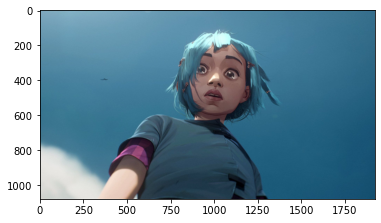

In [3]:
sampleRGB = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
plt.imshow(sampleRGB)
plt.show()

#### 8-bits image

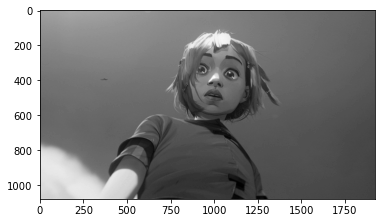

In [4]:
sampleGrayscale = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
plt.imshow(sampleGrayscale, cmap='gray')
plt.show()

#### 1-bit image

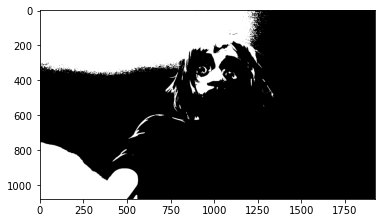

In [5]:
dump, sampleBinary = cv2.threshold(sampleGrayscale, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(sampleBinary, cmap='gray')
plt.show()

### Sample Bit Planes

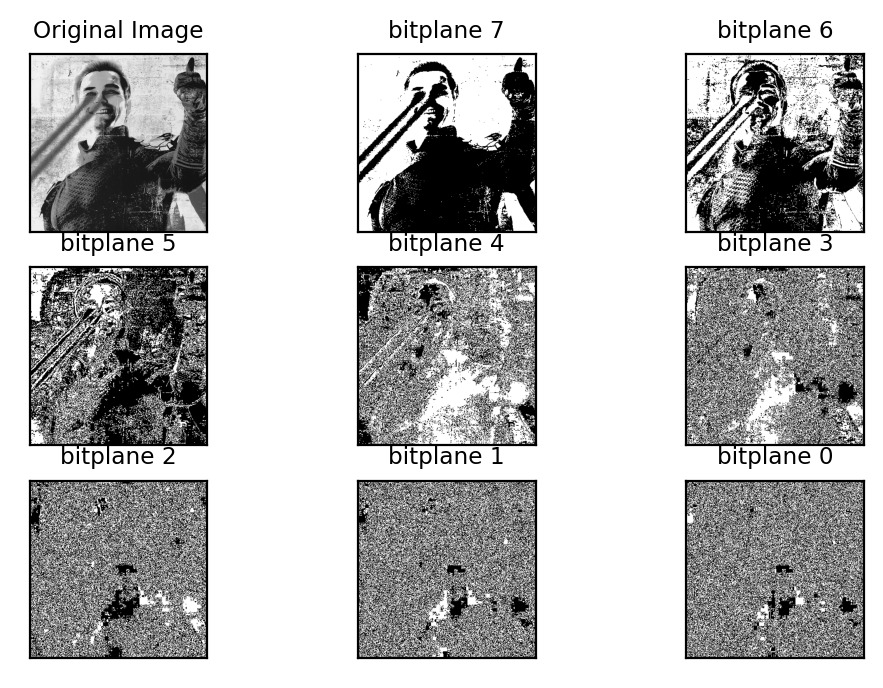

In [6]:
def bitplanes(img, n):
    imgWidth = len(img[0])
    imgLength = len(img)
    img = img.flatten()
    imglen = len(img)

    for i in range(imglen):
        if format(img[i], '#010b')[9-n] == '0':
            img[i] = 0
        else:
            img[i] = 255
    
    newimg = numpy.resize(img, (imgLength, imgWidth))
    return newimg

sample2 = cv2.imread('config/sample2.png', cv2.IMREAD_GRAYSCALE)

samplebitplanes = []
for i in range(8):
    samplebitplanes += [bitplanes(sample2,i)]
samplebitplanes += [sample2]

fig, ax = plt.subplots(3,3)
fig.set_dpi(200)
for i in range(3):
    for j in range(3):
        if i == 0 and j == 0:
            ax[i][j].set_title('Original Image', fontsize='small')
        else:
            ax[i][j].set_title('bitplane ' + str(8-(i*3)-j), fontsize='small')
        ax[i][j].imshow(samplebitplanes[8-(i*3)-j], cmap='gray')
        ax[i][j].get_xaxis().set_ticks([])
        ax[i][j].get_yaxis().set_ticks([])

## Functions
#### functions used for main algorithm

In [7]:
# abstract data type node for huffman tree
class node:
    def __init__(self, freq, symbol, left=None, right=None):
        # symbol character
        self.symbol = symbol
        # symbol frequency
        self.freq = freq
        # left node
        self.left = left
        # right node
        self.right = right
        # huffman code of symbol
        self.huff = ''
        
    # heap priority queue sorting purpose
    def __lt__(self, nxt):
        return self.freq < nxt.freq

    
# recursive function to get huffman codes of all symbols as dictionary
def nodesToDict(node, value=''):
    global huffmanDict
    newValue = value + str(node.huff)
    # base
    if not node.left and not node.right:
        huffmanDict[node.symbol] = newValue
    # recursive
    if node.left: nodesToDict(node.left, newValue)
    if node.right: nodesToDict(node.right, newValue)

        
# take any string text as parameter
# return its huffman codes as dictionary
def textToHuffmanDict(text):
    global huffmanDict
    huffmanDict  = {}
    nodes = []

    # get frequency of every symbols in text
    frequency = sorted(collections.Counter(text).items())

    # push all symbols and its frequency to priority queue nodes
    for x in range(len(frequency)):
        heapq.heappush(nodes, node(frequency[x][1], frequency[x][0]))

    # sort nodes and assign values 
    # then combine 2 smallest nodes to create their parent
    while len(nodes) > 1:
        left = heapq.heappop(nodes)
        right = heapq.heappop(nodes)
        left.huff = 0
        right.huff = 1
        newNode = node(left.freq+right.freq, left.symbol+right.symbol, left, right)
        heapq.heappush(nodes, newNode)

    # convert tree of nodes to huffman dictionary
    nodesToDict(nodes[0])
    return collections.OrderedDict(sorted(huffmanDict.items()))


# encode string text to huffman bit sequence
def encodeTextToHuffmanCode(text, huffmanDict):
    newcode = ''
    for char in text:
        newcode += huffmanDict[char]
    return newcode


# decode huffman bit sequence to string text
def decodeHuffmanCodeToText(huffmanDict, binary):
    counter = 0
    ret_str = ''
    key_list = list(huffmanDict.keys())
    val_list = list(huffmanDict.values())
    while counter < len(binary):
        i = 1
        while binary[counter:counter+i] not in val_list:
            i += 1
        ret_str += key_list[val_list.index(binary[counter:counter+i])]
        counter += i
    return ret_str


# embed binary sequence to image
def embedBinaryToCover(img, binary):
    imgWidth = len(img[0])
    imgLength = len(img)
    pixbit = len(img.shape)
    img = img.flatten()
    binary = '{0:b}'.format(len(binary)).zfill(32) + binary

    for i in range(len(binary)):
        if img[i] % 2 == 0 and binary[i] == '1':
            img[i] += 1
        if img[i] % 2 == 1 and binary[i] == '0':
            img[i] -= 1
    
    if pixbit == 3:
        newimg = numpy.resize(img, (imgLength, imgWidth, 3))
    else:
        newimg = numpy.resize(img, (imgLength, imgWidth))
    return newimg


# extraxt binary sequence from image
def extractBinaryFromObject(img):
    img = img.flatten()
    imglen = int(''.join(format(i%2) for i in img[:32]), 2)
    bincode = ''.join(format(i%2) for i in img[32:32+imglen])
    return bincode

# return Steganalysis Enhanced LSB Method of img
def steganalisis(img):
    imgWidth = len(img[0])
    imgLength = len(img)
    pixbit = len(img.shape)
    img = img.flatten()
    imglen = len(img)

    for i in range(imglen):
        if img[i] % 2 == 0:
            img[i] = 0
        if img[i] % 2 == 1:
            img[i] = 255
    
    if pixbit == 3:
        newimg = numpy.resize(img, (imgLength, imgWidth, 3))
    else:
        newimg = numpy.resize(img, (imgLength, imgWidth))
    return newimg

## Embedded Message

In [8]:
with open('config/embedded_message.txt', 'r') as f: text = f.read()
print(text)

Is this the real life?
Is this just fantasy?
Caught in a landslide
No escape from reality
Open your eyes
Look up to the skies and see
I'm just a poor boy, I need no sympathy
Because I'm easy come, easy go
A little high, little low
Anyway the wind blows, doesn't really matter to me, to me

Mama, just killed a man
Put a gun against his head
Pulled my trigger, now he's dead
Mama, life had just begun
But now I've gone and thrown it all away
Mama, ooo
Didn't mean to make you cry
If I'm not back again this time tomorrow
Carry on, carry on, as if nothing really matters

Too late, my time has come
Sends shivers down my spine
Body's aching all the time
Goodbye everybody - I've got to go
Gotta leave you all behind and face the truth
Mama, ooo - (anyway the wind blows)
I don't want to die
I sometimes wish I'd never been born at all

I see a little silhouetto of a man
Scaramouch, scaramouch will you do the fandango
Thunderbolt and lightning - very very frightening me
Gallileo, Gallileo,
Gallileo, 

### Huffman Codes and Frequency

In [9]:
frequency = dict(collections.Counter(text).items())
frequency = list(collections.OrderedDict(sorted(frequency.items())).values())

huffmanDict = textToHuffmanDict(text)
hdvList = list(huffmanDict.values())
hdkList = list(huffmanDict.keys())

huffmanCode = encodeTextToHuffmanCode(text, huffmanDict)

pandas.DataFrame(list(zip(hdkList, frequency, hdvList)), columns=['Symbol', 'Frequency', 'Huffman Code'])

,Symbol,Frequency,Huffman Code
0,\n,63,10100
1,,333,00
2,!,3,011000000
3,',14,0111000
4,(,2,0110000111
5,),2,1011010010
6,",",27,011001
7,-,16,1011001
8,.,3,011000001
9,?,2,1011000110


## Cover-Object RGB

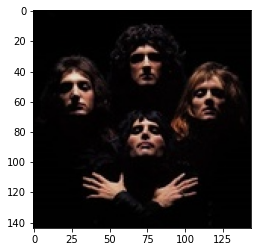

In [10]:
cover = cv2.imread('config/cover-object.png')
plt.imshow(cv2.cvtColor(cover, cv2.COLOR_BGR2RGB))
plt.show()

## Stego-object with compressed message

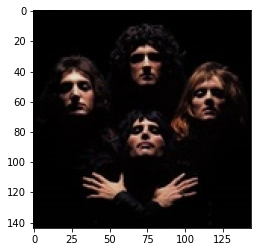

In [11]:
stego = embedBinaryToCover(cover, huffmanCode)
plt.imshow(cv2.cvtColor(stego, cv2.COLOR_BGR2RGB))
plt.show()

## Stego-object with uncompressed message

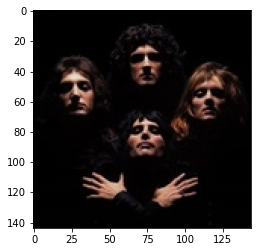

In [12]:
uncompressedText = ''.join(format(ord(i), '08b') for i in text)
stegoUncompressed = embedBinaryToCover(cover, uncompressedText)
plt.imshow(cv2.cvtColor(stegoUncompressed, cv2.COLOR_BGR2RGB))
plt.show()

## Enhanced LSB of cover-object RGB

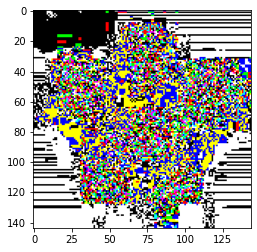

In [13]:
analysis = steganalisis(cover)
plt.imshow(cv2.cvtColor(analysis, cv2.COLOR_BGR2RGB))
plt.show()

## Enhanced LSB of stego-object with compressed message

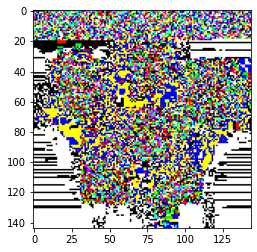

In [14]:
analysis = steganalisis(stego)
plt.imshow(cv2.cvtColor(analysis, cv2.COLOR_BGR2RGB))
plt.show()

## Enhanced LSB of stego-object with uncompressed message

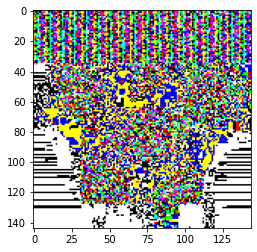

In [15]:
analysis = steganalisis(stegoUncompressed)
plt.imshow(cv2.cvtColor(analysis, cv2.COLOR_BGR2RGB))
plt.show()

## Extracted Message from stego-object RGB

In [16]:
extractedBinary = extractBinaryFromObject(stego)
decodedMessage = decodeHuffmanCodeToText(huffmanDict, extractedBinary)
print(decodedMessage)

Is this the real life?
Is this just fantasy?
Caught in a landslide
No escape from reality
Open your eyes
Look up to the skies and see
I'm just a poor boy, I need no sympathy
Because I'm easy come, easy go
A little high, little low
Anyway the wind blows, doesn't really matter to me, to me

Mama, just killed a man
Put a gun against his head
Pulled my trigger, now he's dead
Mama, life had just begun
But now I've gone and thrown it all away
Mama, ooo
Didn't mean to make you cry
If I'm not back again this time tomorrow
Carry on, carry on, as if nothing really matters

Too late, my time has come
Sends shivers down my spine
Body's aching all the time
Goodbye everybody - I've got to go
Gotta leave you all behind and face the truth
Mama, ooo - (anyway the wind blows)
I don't want to die
I sometimes wish I'd never been born at all

I see a little silhouetto of a man
Scaramouch, scaramouch will you do the fandango
Thunderbolt and lightning - very very frightening me
Gallileo, Gallileo,
Gallileo, 

## Cover-object Grayscale

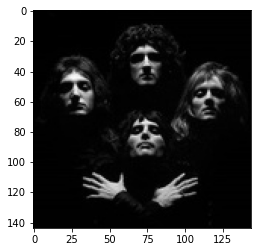

In [17]:
coverGrayscale = cv2.cvtColor(cover, cv2.COLOR_BGR2GRAY)
plt.imshow(coverGrayscale, cmap='gray')
plt.show()

## Stego-object Grayscale with compressed message

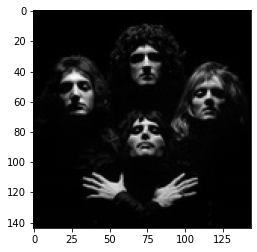

In [18]:
stegoGrayscale = embedBinaryToCover(coverGrayscale, huffmanCode)
plt.imshow(stegoGrayscale, cmap='gray')
plt.show()

## Stego-object Grayscale with uncompressed message

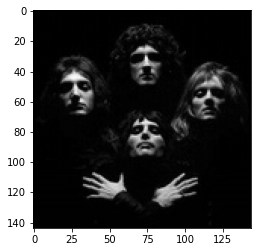

In [19]:
stegoGrayscaleUncompressed = embedBinaryToCover(coverGrayscale, uncompressedText)
plt.imshow(stegoGrayscaleUncompressed, cmap='gray')
plt.show()

## Enhanced LSB of cover-object Grayscale

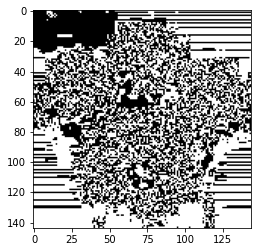

In [20]:
analysis = steganalisis(coverGrayscale)
plt.imshow(analysis, cmap='gray')
plt.show()

## Enhanced LSB of stego-object with compressed message

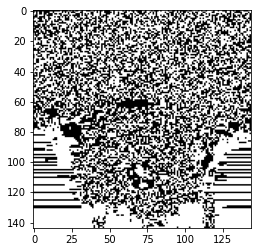

In [21]:
analysis = steganalisis(stegoGrayscale)
plt.imshow(analysis, cmap='gray')
plt.show()

## Enhanced LSB of stego-object with uncompressed message

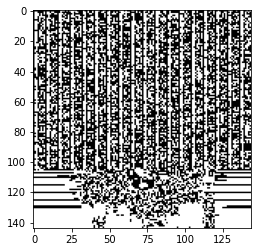

In [22]:
analysis = steganalisis(stegoGrayscaleUncompressed)
plt.imshow(analysis, cmap='gray')
plt.show()

## Extracted Message from stego-object Grayscale

In [23]:
extractedBinary = extractBinaryFromObject(stegoGrayscale)
decodedMessage = decodeHuffmanCodeToText(huffmanDict, extractedBinary)
print(decodedMessage)

Is this the real life?
Is this just fantasy?
Caught in a landslide
No escape from reality
Open your eyes
Look up to the skies and see
I'm just a poor boy, I need no sympathy
Because I'm easy come, easy go
A little high, little low
Anyway the wind blows, doesn't really matter to me, to me

Mama, just killed a man
Put a gun against his head
Pulled my trigger, now he's dead
Mama, life had just begun
But now I've gone and thrown it all away
Mama, ooo
Didn't mean to make you cry
If I'm not back again this time tomorrow
Carry on, carry on, as if nothing really matters

Too late, my time has come
Sends shivers down my spine
Body's aching all the time
Goodbye everybody - I've got to go
Gotta leave you all behind and face the truth
Mama, ooo - (anyway the wind blows)
I don't want to die
I sometimes wish I'd never been born at all

I see a little silhouetto of a man
Scaramouch, scaramouch will you do the fandango
Thunderbolt and lightning - very very frightening me
Gallileo, Gallileo,
Gallileo, 

# CAPACITY ANALYSIS

## Compression rate

In [24]:
lenOrdinarySeq = len(text) * 8
lenHuffmanSeq = len(huffmanCode)
print('Length sequence without compression:', lenOrdinarySeq)
print('Length sequence with compression   :', lenHuffmanSeq)
print(f'Compression rate: {(lenOrdinarySeq - lenHuffmanSeq)*100/lenOrdinarySeq:0.2f}%')

Length sequence without compression: 15096
Length sequence with compression   : 8531
Compression rate: 43.49%


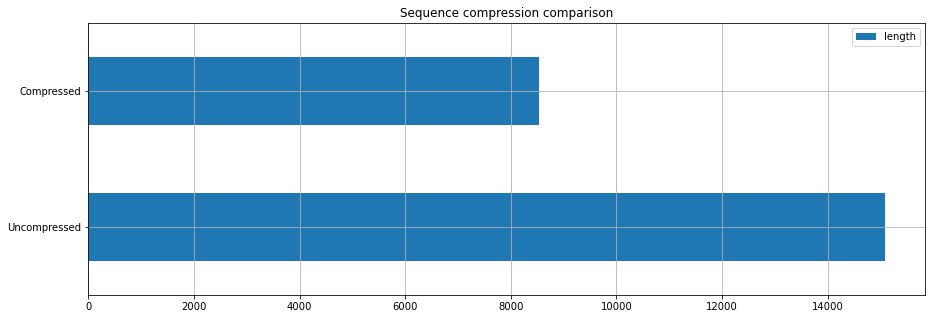

In [25]:
cr = pandas.DataFrame([lenOrdinarySeq, lenHuffmanSeq], index=['Uncompressed', 'Compressed'], columns=['length'])
cr.plot(kind='barh', figsize=(15,5), grid=True)
plt.title('Sequence compression comparison')
plt.show()

## Capacity used comparison on RGB Image

In [26]:
capRGB = numpy.size(cover)
print(f'Cover dimension: {len(cover)}x{len(cover[0])}')
print('Cover size:', capRGB)
print(f'Percentage capacity used on uncompressed message: {lenOrdinarySeq*100/capRGB:0.2f}%')
print(f'Percentage capacity used on compressed message  : {lenHuffmanSeq*100/capRGB:0.2f}%')

Cover dimension: 144x144
Cover size: 62208
Percentage capacity used on uncompressed message: 24.27%
Percentage capacity used on compressed message  : 13.71%


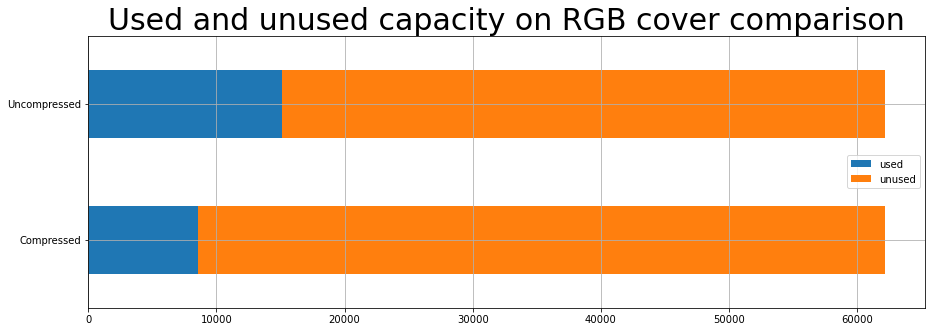

In [27]:
dfRGB = pandas.DataFrame(list(zip([capRGB-lenHuffmanSeq, capRGB-lenOrdinarySeq], [lenHuffmanSeq, lenOrdinarySeq])),
                         index=['Compressed', 'Uncompressed'], columns=['used', 'unused'])
dfRGB.plot(kind='barh', y={'used', 'unused'}, label=['used', 'unused'], stacked=True, grid=True, figsize=(15,5))
plt.title('Used and unused capacity on RGB cover comparison', fontsize=30)
plt.show()

## Capacity used comparison on Grayscale Image

In [28]:
capGS = numpy.size(coverGrayscale)
print(f'Cover dimension: {len(coverGrayscale)}x{len(coverGrayscale[0])}')
print('Cover size:', capGS)
print(f'Percentage capacity used on uncompressed message: {lenOrdinarySeq*100/capGS:0.2f}%')
print(f'Percentage capacity used on compressed message  : {lenHuffmanSeq*100/capGS:0.2f}%')

Cover dimension: 144x144
Cover size: 20736
Percentage capacity used on uncompressed message: 72.80%
Percentage capacity used on compressed message  : 41.14%


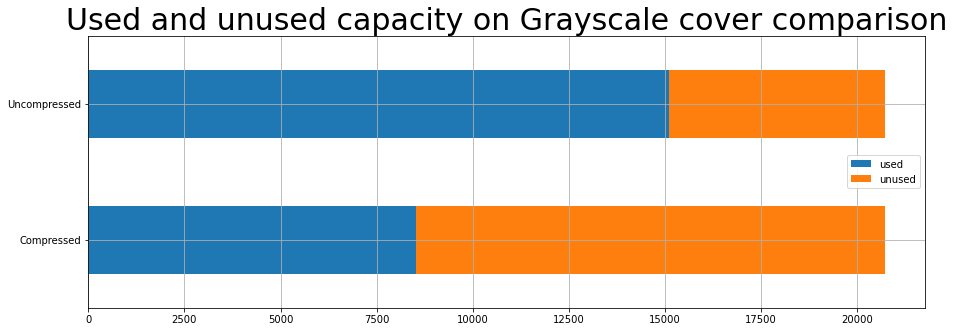

In [29]:
dfGS = pandas.DataFrame(list(zip([capGS-lenHuffmanSeq, capGS-lenOrdinarySeq], [lenHuffmanSeq, lenOrdinarySeq])),
                         index=['Compressed', 'Uncompressed'], columns=['used', 'unused'])
dfGS.plot(kind='barh', y={'used', 'unused'}, label=['used', 'unused'], stacked=True, grid=True, figsize=(15,5))
plt.title('Used and unused capacity on Grayscale cover comparison', fontsize=30)
plt.show()